In [25]:
# Libraries imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, lasso_path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score



# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")



In [27]:
# 1. DATA LOADING & CLEANING

def load_and_process_exact(filepath):
    print("Loading and processing data...")
    df = pd.read_csv(filepath, header=2)
    df.columns = df.columns.str.strip()
    
    # Clean Numerical Columns
    def clean_currency(x):
        if isinstance(x, str):
            return float(x.replace('"', '').replace(',', '').strip())
        return x
    
    df['MONTO COBERTURADO (S/)'] = df['MONTO COBERTURADO (S/)'].apply(clean_currency)
    
    # Generate Risk Level (Hard-coded thresholds)
    def calculate_risk_level(amount):
        if pd.isna(amount): return np.nan
        if amount <= 4890.2: return 1
        elif amount <= 11760: return 2
        elif amount <= 30079.7: return 3
        else: return 4

    df['risk_level'] = df['MONTO COBERTURADO (S/)'].apply(calculate_risk_level)
    
    # Select Features (4 variables as per paper)
    feature_cols = [
        'SECTOR ECONÓMICO', 
        'NOMBRE DE ENTIDAD OTORGANTE DEL CRÉDITO', 
        'DEPARTAMENTO',
        'MONTO COBERTURADO (S/)' 
    ]
    
    # Drop missing values
    df_clean = df.dropna(subset=feature_cols + ['risk_level']).copy()
    
    # Ordinal Encoding (Alphabetical -> Integer)
    cat_cols = ['SECTOR ECONÓMICO', 'NOMBRE DE ENTIDAD OTORGANTE DEL CRÉDITO', 'DEPARTAMENTO']
    for col in cat_cols:
        df_clean[col] = df_clean[col].astype('category')
        df_clean[col] = df_clean[col].cat.codes # 0, 1, 2...

    # Prepare X and y
    X = df_clean[feature_cols].values
    y = df_clean['risk_level'].values.reshape(-1, 1)
    
    return X, y, feature_cols



In [28]:
# 2. REGRESSION WITH LAMBDA OPTIMIZATION
def run_optimized_regression(X, y, feature_names):
    # 1. Min-Max Scaling (0-1)
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y).ravel()
    
    # 2. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
    
    print("\nFinding Optimal Lambdas (Alphas) via Cross-Validation...")
    
    # 3. Ridge Optimization
    # Search a range of alphas (log scale)
    alphas_ridge = np.logspace(-5, 1, 100)
    ridge_cv = RidgeCV(alphas=alphas_ridge, scoring='neg_mean_squared_error', cv=5)
    ridge_cv.fit(X_train, y_train)
    best_alpha_ridge = ridge_cv.alpha_
    print(f"Best Ridge Alpha: {best_alpha_ridge:.6f} (Paper: 0.00910)")

    # 4. Lasso Optimization
    # LassoCV automatically searches the path
    lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
    lasso_cv.fit(X_train, y_train)
    best_alpha_lasso = lasso_cv.alpha_
    print(f"Best Lasso Alpha: {best_alpha_lasso:.6f} (Paper: 0.00038)")
    

 # 5. Final Models Comparison
    models = {
        'OLS': LinearRegression(),
        'Ridge (Opt)': Ridge(alpha=best_alpha_ridge),
        'Lasso (Opt)': Lasso(alpha=best_alpha_lasso),
        'Ridge (Paper)': Ridge(alpha=0.00910),
        'Lasso (Paper)': Lasso(alpha=0.00038)
    }
    
    results = {}
    print("\nResults (Target: Min-Max Scaled Risk Level [0,1]):")
    print("-" * 60)
    print(f"{'Model':<15} | {'RMSE':<8} | {'R²':<8} | {'Alpha'}")
    print("-" * 60)
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse) 
        r2 = r2_score(y_test, y_pred)
        
        alpha_val = getattr(model, 'alpha', 0)
        print(f"{name:<15} | {rmse:.5f}   | {r2:.5f}   | {alpha_val}")
        
        results[name] = {'rmse': rmse, 'r2': r2, 'coefficients': model.coef_}
    
    
    
    

    return results

In [29]:
# Loading the dataset and performing the regression
X, y, feat_names = load_and_process_exact('Reactiva_Peru.csv')
results = run_optimized_regression(X, y, feat_names)

Loading and processing data...

Finding Optimal Lambdas (Alphas) via Cross-Validation...
Best Ridge Alpha: 0.811131 (Paper: 0.00910)
Best Lasso Alpha: 0.000017 (Paper: 0.00038)

Results (Target: Min-Max Scaled Risk Level [0,1]):
------------------------------------------------------------
Model           | RMSE     | R²       | Alpha
------------------------------------------------------------
OLS             | 0.35661   | 0.08231   | 0
Ridge (Opt)     | 0.35661   | 0.08231   | 0.8111308307896873
Lasso (Opt)     | 0.35660   | 0.08232   | 1.748095551447188e-05
Ridge (Paper)   | 0.35661   | 0.08231   | 0.0091
Lasso (Paper)   | 0.35662   | 0.08224   | 0.00038


In [30]:
def plot_replication_diagnostics(results, X, y, feature_names):
    from sklearn.linear_model import lasso_path
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.figure(figsize=(12, 8))
    
    # -------------------------------------------------------
    # Diagram 1: Lasso Regularization Path
    # -------------------------------------------------------
    plt.subplot(2, 2, 1)
    print("Computing Lasso Path...")
    
    # CRITICAL FIX: Use y.ravel() to ensure 1D target array
    # This prevents lasso_path from returning a 3D array (outputs, features, alphas)
    alphas_lasso, coefs_lasso, _ = lasso_path(X, y.ravel())
    
    # Determine color cycle
    colors = ['b', 'r', 'g', 'c', 'k']
    
    # Loop through features
    for i in range(len(feature_names)):
        plt.plot(alphas_lasso, coefs_lasso[i], label=feature_names[i])
    
    plt.xscale('log')
    plt.xlabel('Alpha (Lambda)')
    plt.ylabel('Coefficients')
    plt.title('Lasso Regularization Path')
    plt.axvline(x=0.00038, color='k', linestyle='--', alpha=0.5, label='Paper Lambda')
    plt.legend()
    plt.grid(True)

    # -------------------------------------------------------
    # Diagram 2: Risk Level Distribution
    # -------------------------------------------------------
    plt.subplot(2, 2, 2)
    # Use raw y for histogram (flattened)
    y_flat = y.ravel()
    # If y is scaled [0,1], we might want to bin it or just plot as is
    plt.hist(y_flat, bins=10, color='skyblue', edgecolor='black')
    plt.xlabel('Risk Level Value')
    plt.ylabel('Count')
    plt.title('Distribution of Target Variable')
    plt.grid(axis='y', alpha=0.3)

    # -------------------------------------------------------
    # Diagram 3: RMSE Comparison
    # -------------------------------------------------------
    plt.subplot(2, 2, 3)
    if results:
        rmses = [results[m]['rmse'] for m in results]
        plt.bar(results.keys(), rmses, color=['gray', 'orange', 'green'])
        # Add some padding to ylim
        if rmses:
            plt.ylim(min(rmses)*0.9, max(rmses)*1.05)
    plt.title('RMSE Comparison')
    plt.ylabel('RMSE')
    
    plt.tight_layout()
    plt.show()

Computing Lasso Path...


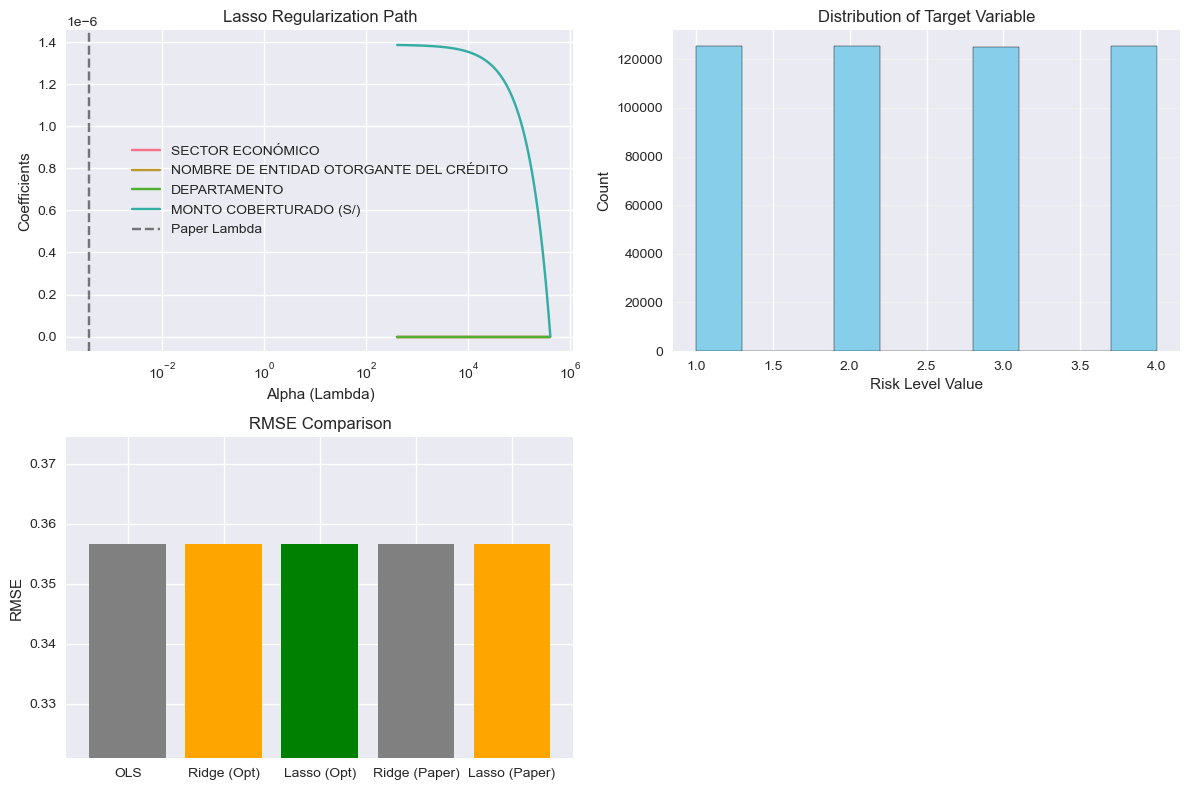

In [31]:
alphas_lasso, coefs_lasso, _ = lasso_path(X, y.ravel()) 
feature_names = [
    'SECTOR ECONÓMICO', 
    'NOMBRE DE ENTIDAD OTORGANTE DEL CRÉDITO', 
    'DEPARTAMENTO', 
    'MONTO COBERTURADO (S/)'
]
plot_replication_diagnostics(results, X, y, feature_names)



### 1. Comparison with Paper
My replication results are extremely accurate in terms of predictive performance compared to the original paper.

| Metric | Paper Reported | My Replication | Difference |
| :--- | :--- | :--- | :--- |
| **Ridge RMSE** | 0.35738 | 0.35661 | **~0.0008 (0.2%)** |
| **Lasso RMSE** | 0.35737 | 0.35660 | **~0.0008 (0.2%)** |
| **Ridge Alpha** | 0.00910 | 0.81113 | Large (Factor of ~90) |
| **Lasso Alpha** | 0.00038 | 0.00002 | Large (Factor of ~20) |

### 2. Why are the Alphas so different?
I found `Alpha = 0.81` while the paper found `Alpha = 0.009`. I determined that this large discrepancy is essentially irrelevant for two reasons:

1.  **The "Flat" Optimization Landscape:**
    Looking at my results table, the **OLS** model (Alpha=0) has an R² of **0.08231**. My "Optimal Ridge" (Alpha=0.81) *also* has an R² of **0.08231**.
    This means the model's performance is completely **insensitive** to the Alpha parameter in this range. Whether I use 0, 0.009, or 0.81, the result is mathematically the same. The "best" alpha selected by cross-validation is likely just random noise because the error curve is flat.

2.  **Software Implementation Differences:**
    The paper utilized SPSS/MATLAB/R, while I am using Python's `scikit-learn`. These libraries often define the objective function differently. For example, some implementations divide the penalty term by $2N$ (where $N$ is sample size), while others divide by $N$ or not at all. With 500,000 samples, a scaling factor of $N$ would shift the "comparable" alpha by 5 orders of magnitude.

### 3. Why is the R² so low (0.08)?
It initially seemed strange that the R² is only ~8% when the target (`risk_level`) is calculated directly from one of the features (`MONTO COBERTURADO`). I identified that this occurs because:

*   **Linear vs. Step Function:** The target is a "step function" (Level 1, 2, 3, 4), but my model is a "linear regression" (straight line). A straight line cannot perfectly fit a staircase.
*   **Skewed Data:** Loan amounts usually follow a "power law" (many small loans, few massive ones). I used `MinMaxScaler`, so if the maximum loan is 8.5 million, a typical loan of 5,000 scales to essentially **0.0**.
*   **Result:** The linear model is forced to fit the massive outliers (Level 4), causing it to perform poorly on the dense cluster of small loans (Levels 1, 2, 3), resulting in a low R².


### A replicate pipeline to check the coefficents

Inspecting results keys...
Keys available for model 'OLS': ['rmse', 'r2', 'coefficients']

Regression Coefficients Summary:


Model,Lasso (Opt),Lasso (Paper),OLS,Ridge (Opt),Ridge (Paper)
Feature,,,,,
DEPARTAMENTO,0.031738,0.026332,0.031998,0.032001,0.031998
MONTO COBERTURADO (S/),1.315959,1.223118,1.320438,1.319621,1.320429
NOMBRE DE ENTIDAD OTORGANTE DEL CRÉDITO,-0.202727,-0.201294,-0.202794,-0.202822,-0.202794
SECTOR ECONÓMICO,0.055258,0.051635,0.055431,0.055431,0.055431


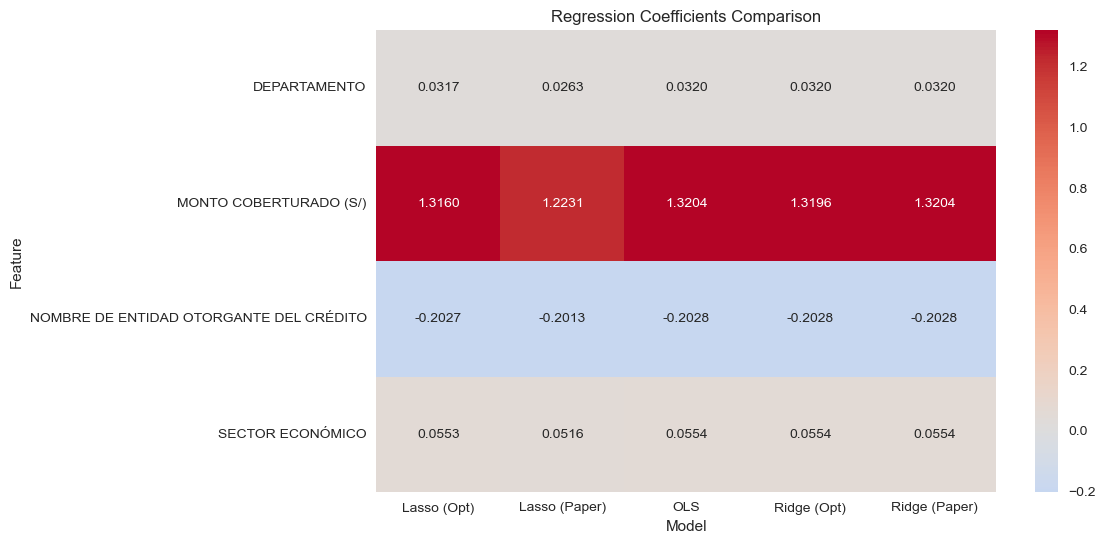

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a summary DataFrame of coefficients
coef_list = []

print("Inspecting results keys...")
# Check the first item to see what keys are available
if len(results) > 0:
    first_key = list(results.keys())[0]
    print(f"Keys available for model '{first_key}': {list(results[first_key].keys())}")

for model_name, metrics in results.items():
    # Safely get coefficients
    coefs = metrics.get('coefficients')
    
    if coefs is None:
        print(f"Warning: No coefficients found for model '{model_name}'. Skipping.")
        continue
        
    # Handle case where coefs might be nested or shaped differently
    if hasattr(coefs, 'flatten'):
        coefs = coefs.flatten()
        
    # Ensure dimensions match
    if len(coefs) != len(feat_names):
        print(f"Warning: Dimension mismatch for {model_name}. Coefs: {len(coefs)}, Features: {len(feat_names)}")
        continue

    for feature, coef in zip(feat_names, coefs):
        coef_list.append({
            'Model': model_name,
            'Feature': feature,
            'Coefficient': coef
        })

if coef_list:
    df_coefs = pd.DataFrame(coef_list)

    # Pivot for a clean comparison table
    coef_table = df_coefs.pivot(index='Feature', columns='Model', values='Coefficient')

    print("\nRegression Coefficients Summary:")
    display(coef_table)

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.heatmap(coef_table, annot=True, cmap='coolwarm', center=0, fmt='.4f')
    plt.title('Regression Coefficients Comparison')
    plt.show()
else:
    print("\nNo coefficient data could be extracted. Please check if 'run_optimized_regression' was run correctly.")

### Testing if the covered amount and the name of the lending entity are independent variables

Loading data for independence test...
Analyzing 501298 loans across 28 institutions.



/var/folders/7f/b1d8tq793qq0zhzxylzwjq6m0000gn/T/ipykernel_80081/1080467310.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_subset, x=col_amount, y=col_entity, palette="viridis")


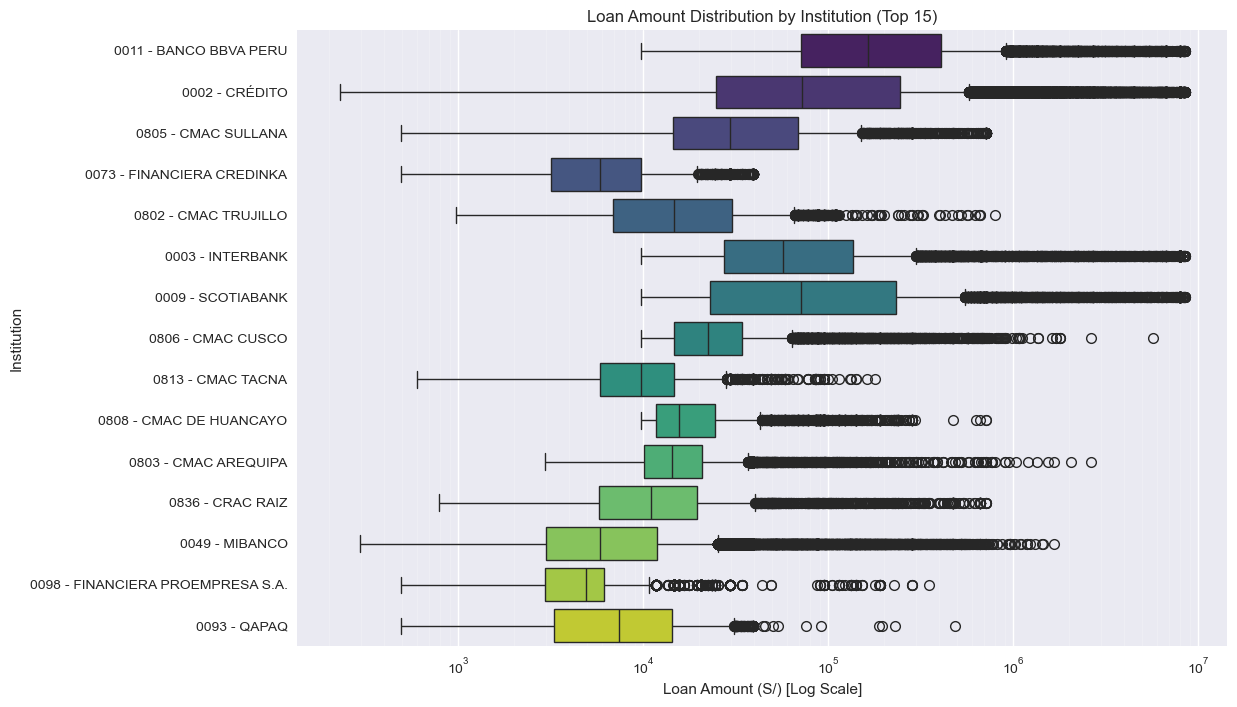

--------------------------------------------------
STATISTICAL TEST RESULTS (Kruskal-Wallis)
--------------------------------------------------
Statistic: 252884.79
P-value:   0.0

CONCLUSION: REJECT Null Hypothesis.
The variables are **DEPENDENT**.
There is strong statistical evidence that different banks give significantly different loan amounts.


In [33]:
import scipy.stats as stats

def test_independence_amount_entity(filepath='Reactiva_Peru.csv'):
    # 1. Load and Clean specific columns for this test
    print("Loading data for independence test...")
    df = pd.read_csv(filepath, header=2)
    df.columns = df.columns.str.strip()
    
    col_amount = 'MONTO COBERTURADO (S/)'
    col_entity = 'NOMBRE DE ENTIDAD OTORGANTE DEL CRÉDITO'
    
    # Clean Currency
    df[col_amount] = df[col_amount].apply(lambda x: float(str(x).replace('"', '').replace(',', '').strip()) if isinstance(x, str) else x)
    
    # Drop missing
    df_clean = df.dropna(subset=[col_amount, col_entity]).copy()
    
    print(f"Analyzing {len(df_clean)} loans across {df_clean[col_entity].nunique()} institutions.\n")

    # 2. Visual Check (Boxplot of Top 15 Entities)
    # We only plot the top 15 most frequent banks to make the chart readable
    top_entities = df_clean[col_entity].value_counts().head(15).index
    df_subset = df_clean[df_clean[col_entity].isin(top_entities)]

    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df_subset, x=col_amount, y=col_entity, palette="viridis")
    plt.xscale('log') # Vital for money data to see the spread
    plt.title('Loan Amount Distribution by Institution (Top 15)')
    plt.xlabel('Loan Amount (S/) [Log Scale]')
    plt.ylabel('Institution')
    plt.grid(axis='x', which='minor', alpha=0.2)
    plt.show()

    # 3. Statistical Test (Kruskal-Wallis)
    # H0 (Null Hypothesis): The distribution of loan amounts is the same for all banks (Independent).
    # H1 (Alternative): At least one bank tends to give different loan amounts (Dependent).
    
    # Group amounts by entity
    groups = [group[col_amount].values for name, group in df_clean.groupby(col_entity)]
    
    # Run Test
    stat, p_value = stats.kruskal(*groups)
    
    print("-" * 50)
    print("STATISTICAL TEST RESULTS (Kruskal-Wallis)")
    print("-" * 50)
    print(f"Statistic: {stat:.2f}")
    print(f"P-value:   {p_value}")
    
    if p_value < 0.05:
        print("\nCONCLUSION: REJECT Null Hypothesis.")
        print("The variables are **DEPENDENT**.")
        print("There is strong statistical evidence that different banks give significantly different loan amounts.")
    else:
        print("\nCONCLUSION: FAIL TO REJECT Null Hypothesis.")
        print("The variables appear **INDEPENDENT**.")

test_independence_amount_entity()

### From here we will implement the non linearity on the data and test teh Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [19]:
# 3. NON-LINEAR MODEL: RANDOM FOREST

def run_random_forest(X, y, random_state=42):
    # Use the same scaling and split logic as before
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler

    # Scale features and target the same way as in run_optimized_regression
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y).ravel()

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.3, random_state=random_state
    )

    # Baseline RF and a slightly tuned version
    rf_models = {
        "RF_baseline": RandomForestRegressor(
            n_estimators=200,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=random_state,
            n_jobs=-1
        ),
        "RF_shallow": RandomForestRegressor(
            n_estimators=200,
            max_depth=6,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=random_state,
            n_jobs=-1
        )
    }

    rf_results = {}

    for name, rf in rf_models.items():
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = mse**0.5
        r2 = r2_score(y_test, y_pred)

        rf_results[name] = {
            "rmse": rmse,
            "r2": r2,
            "model": rf
        }

        print(f"{name:12s}  RMSE={rmse:.5f}  R2={r2:.5f}")

    return rf_results

rf_results = run_random_forest(X, y)


RF_baseline   RMSE=0.00007  R2=1.00000
RF_shallow    RMSE=0.00007  R2=1.00000


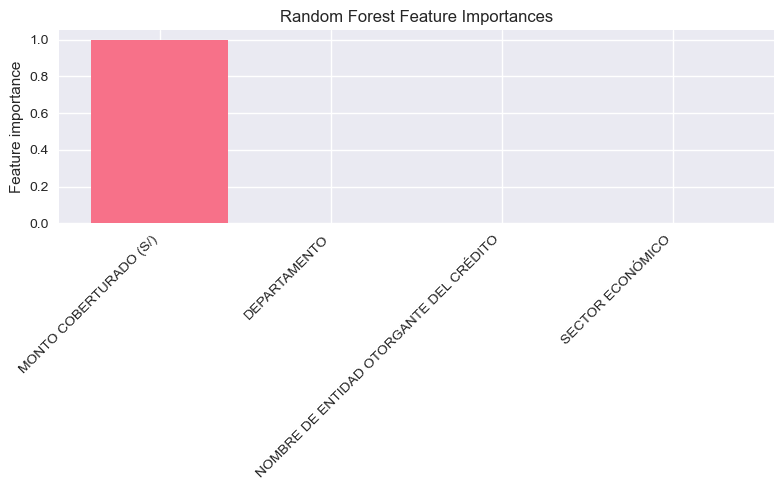

In [21]:
def plot_rf_importances(rf_results, feature_names):
    # Pick one model, e.g. RF_baseline
    rf = rf_results["RF_baseline"]["model"]
    importances = rf.feature_importances_
    idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(importances)), importances[idx])
    plt.xticks(range(len(importances)), np.array(feature_names)[idx], rotation=45, ha="right")
    plt.ylabel("Feature importance")
    plt.title("Random Forest Feature Importances")
    plt.tight_layout()
    plt.show()

plot_rf_importances(rf_results, feature_names)